In [9]:
import json
from pathlib import Path

import astropy.uncertainty as unc
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LMLSQFitter

from feadme.parser import Template, Parameter, Line, Shape, Disk, Mask

finfo = np.finfo(float)

In [15]:
disk_profile = Disk(
    name="halpha_disk",
    mask=[Mask(lower_limit=6400, upper_limit=6700)],
    center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
    inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3),
    delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e4),
    inclination=Parameter(name="inclination", distribution="normal", low=0, high=np.pi / 2, loc=np.pi / 4, scale=np.pi / 8),
    sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e4),
    q=Parameter(name="q", distribution="uniform", low=0.5, high=4),
    eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1),
    apocenter=Parameter(name="apocenter", distribution="normal", low=0, high=2 * np.pi, loc=np.pi, scale=np.pi / 4),
    scale=Parameter(name="scale", distribution="uniform", low=0, high=1),
    offset=Parameter(name="offset", distribution="uniform", low=0, high=0.05, fixed=False, value=0)
)

halpha_narrow_line = Line(
    name="halpha_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
)

halpha_broad_line = Line(
    name="halpha_broad",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e3, high=2e4),
)

hei_narrow_line = Line(
    name="hei_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6673, high=6683, loc=6678, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
)

white_noise=Parameter(name="white_noise", distribution="uniform", low=-10, high=1)


# test_template = Template(
#     name="test_template",
#     disk_profiles=[
#         Disk(
#             name="halpha_disk",
#             mask=[Mask(lower_limit=6400, upper_limit=6700)],
#             center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
#             inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3),
#             delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e4),
#             inclination=Parameter(name="inclination", distribution="normal", low=0, high=np.pi / 2, loc=np.pi / 4, scale=np.pi / 8),
#             sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e4),
#             q=Parameter(name="q", distribution="uniform", low=0.5, high=4),
#             eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1),
#             apocenter=Parameter(name="apocenter", distribution="normal", low=0, high=2 * np.pi, loc=np.pi, scale=np.pi / 4),
#             scale=Parameter(name="scale", distribution="uniform", low=0, high=1),
#             offset=Parameter(name="offset", distribution="uniform", low=0, high=0.1, fixed=True, value=0)
#         ),
#     ],
#     line_profiles=[
#         Line(
#             name="halpha_narrow",
#             profile=Shape.gaussian,
#             center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
#             amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#             vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
#         ),
#         Line(
#             name="halpha_broad",
#             profile=Shape.gaussian,
#             center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
#             amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#             vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e2, high=1e4),
#         ),
#         Line(
#             name="hei_narrow",
#             profile=Shape.gaussian,
#             center=Parameter(name="center", distribution="normal", low=6673, high=6683, loc=6678, scale=2),
#             amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#             vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
#         ),
#         # Line(
#         #     name="niir_narrow",
#         #     profile=Shape.gaussian,
#         #     center=Parameter(name="center", distribution="normal", low=6583.46 - 5, high=6583.46 + 5, loc=6583.46, scale=2),
#         #     amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#         #     vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3, shared="halpha_narrow"),
#         # ),
#         # Line(
#         #     name="niil_narrow",
#         #     profile=Shape.gaussian,
#         #     center=Parameter(name="center", distribution="normal", low=6548.05 - 5, high=6548.05 + 5, loc=6548.05, scale=2),
#         #     amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#         #     vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3, shared="halpha_narrow"),
#         # ),
#         # Line(
#         #     name="siir_narrow",
#         #     profile=Shape.gaussian,
#         #     center=Parameter(name="center", distribution="normal", low=6730.81 - 5, high=6730.81 + 5, loc=6730.81, scale=2),
#         #     amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#         #     vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3, shared="halpha_narrow"),
#         # ),
#         # Line(
#         #     name="siil_narrow",
#         #     profile=Shape.gaussian,
#         #     center=Parameter(name="center", distribution="normal", low=6716.44 - 5, high=6716.44 + 5, loc=6716.44, scale=2),
#         #     amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
#         #     vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3, shared="halpha_narrow"),
#         # ),
#     ],
#     white_noise=Parameter(name="white_noise", distribution="uniform", low=-10, high=1),
# )
# 
# with open("/home/nmearl/research/tde_agn_comparison/tde_test_template.json", "w") as f:
#     json.dump(test_template.model_dump(), f)

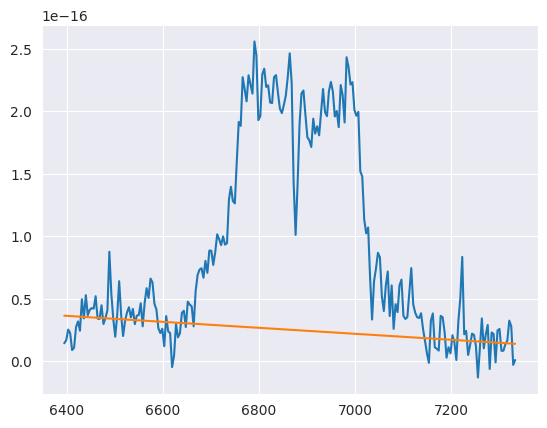

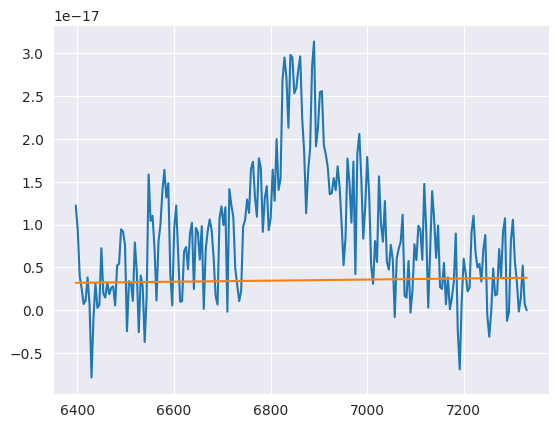

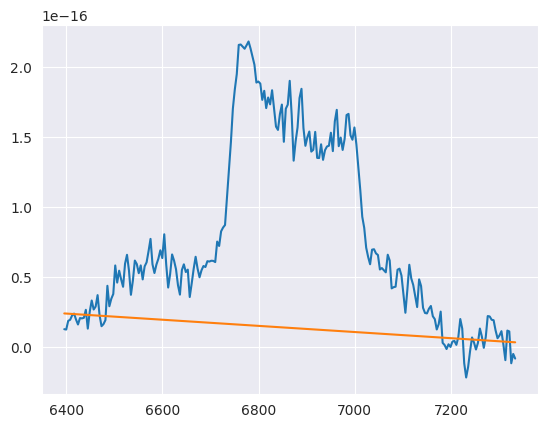

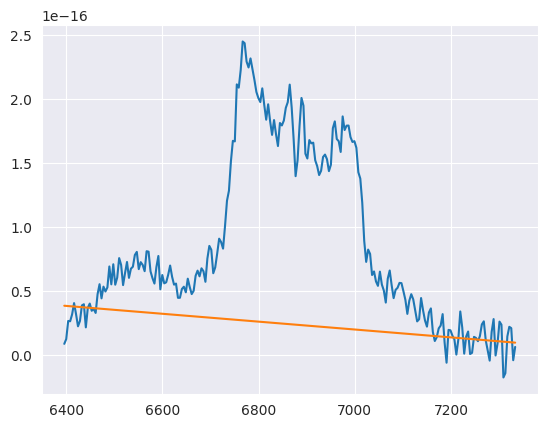

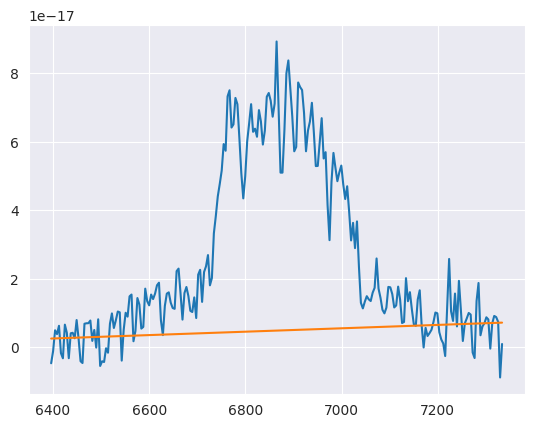

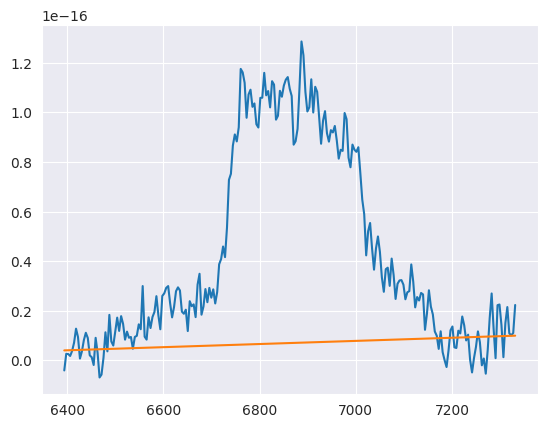

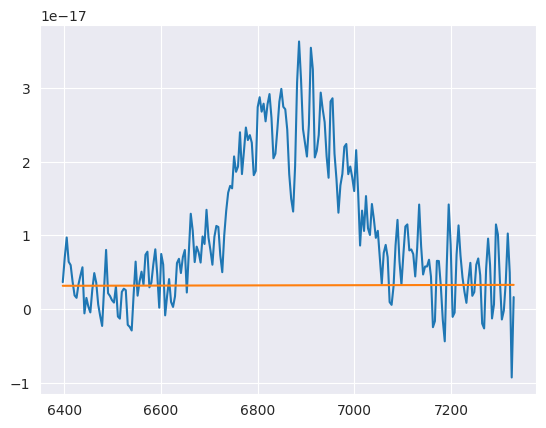

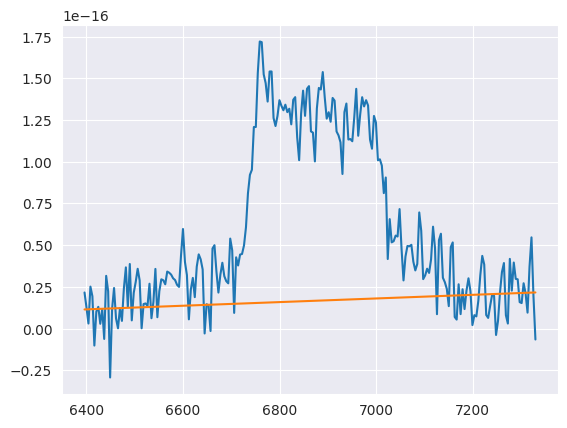

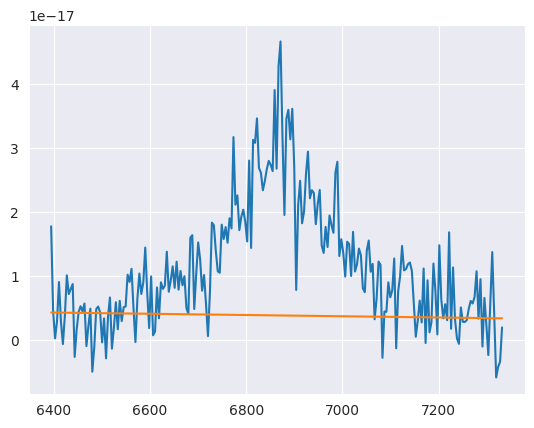

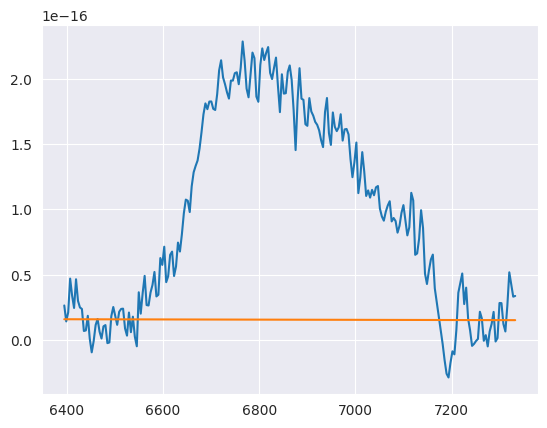

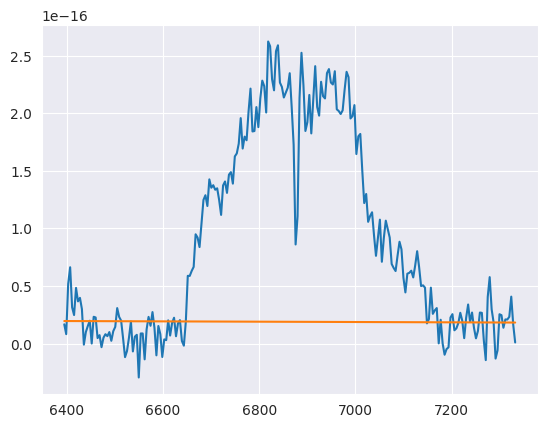

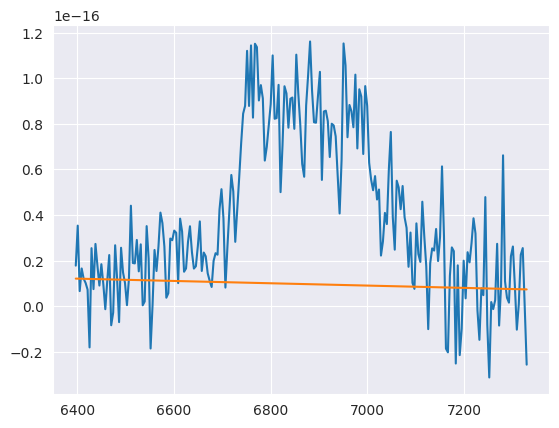

In [19]:
ingest_dir = Path("/home/nmearl/research/tde_agn_comparison/parsed")
output_dir = Path("/home/nmearl/research/tde_agn_comparison")

for file_path in ingest_dir.glob("*.ecsv"):
    for seg in [ '2018hyz']:#, '2018zr', '2020zso',]:#, '14li', '09djl']:
        if seg not in file_path.stem:
            continue
    
        tab = Table.read(file_path, format='ascii.ecsv')
        label = tab.meta['name'].replace(',', '').replace(' ', '')
        redshift = tab.meta['redshift']
        mjd = tab.meta['obs_date']
        
        wave = tab['wave'] * u.AA
        flux = tab['flux'] * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['uncertainty'] * u.erg / u.s / u.cm ** 2 / u.AA
        rest_wave = wave / (1 + redshift)
        ha_mask = (rest_wave.value > 6563 - 350) & (rest_wave.value < 6563 + 350)
        full_mask = (rest_wave.value > 6563 - 450) & (rest_wave.value < 6563 + 450)
        cont_mask = full_mask & ~ha_mask
        
        fit_mod = LMLSQFitter()(Linear1D(), wave[cont_mask], flux[cont_mask])
        cont_flux = fit_mod(wave)
        
        fig, ax = plt.subplots()
        
        ax.plot(wave[full_mask], flux[full_mask], label='Data')
        ax.plot(wave[full_mask], cont_flux[full_mask], label='Continuum')
        
        flux -= cont_flux

        
        flux = flux[ha_mask].to(u.mJy, u.spectral_density(wave[ha_mask]))
        flux_err = flux_err[ha_mask].to(u.mJy, u.spectral_density(wave[ha_mask]))
        wave = wave[ha_mask]
    
        Table({'wave': wave, 'flux': flux, 'flux_err': flux_err}).write(output_dir / "data" / f"{label}_{mjd}.csv", format='ascii.csv', overwrite=True)
        
        template = Template(
            name=label,
            redshift=redshift,
            data_path=str(output_dir / "data" / f"{label}_{mjd}.csv"),
            disk_profiles=[
                disk_profile,
            ],
            line_profiles=[],
            white_noise=white_noise
        )
        
        if '2018zr' in seg:
            template.line_profiles=[
                halpha_broad_line,
            ]
        elif '2020zso' in seg:
            pass
        elif '2018hyz' in seg:
            template.line_profiles=[
                halpha_broad_line,
            ]
        elif '14li' in seg:
            template.line_profiles=[
                halpha_narrow_line,
                halpha_broad_line,
                hei_narrow_line
            ]
        elif '09djl' in seg:
            template.line_profiles=[]
    
        for prof in template.disk_profiles:
            prof.scale.high = flux.max().value * 1.1
    
        for prof in template.line_profiles:
            prof.amplitude.high = flux.max().value * 1.1
    
        with open(output_dir / "tde_templates" / f"{label}_{mjd}.json", "w") as f:
            json.dump(template.model_dump(), f)

# Parse Data

In [ ]:
ingest_dir = Path("/Users/nmearl/Downloads/ZTF-DPEs-main/SDSSspectroscopy")

obj_tab = Table.read("/Users/nmearl/Downloads/ZTF-DPEs-main/object_info.cds", format='ascii.cds')
obj_tab['name'] = [x.strip() for x in obj_tab['ZTF']]
dpe_tab = Table.read("/Users/nmearl/Downloads/ZTF-DPEs-main/dpe_info.cds", format='ascii.cds')
dpe_tab['name'] = [x.strip() for x in dpe_tab['ZTF']]

output_dir = Path("/Users/nmearl/research/tde_agn_comparison")
# data_path = Path("/Users/nmearl/research/tde_agn_comparison/data").glob("*.txt")

for file_path in ingest_dir.glob("*.ecsv"):
    label = file_path.stem.split('_')[0]

    if label not in dpe_tab['name']:
        continue

    tab = Table.read(file_path, format='ascii.basic', names=['wave', 'flux', 'flux_err'])
    redshift = obj_tab[obj_tab['name'] == label]['z'].value.data[0]

    if not redshift:
        print(f"{label} has missing redshift")
        continue

    # ==============
    # Parse and transform data
    # ==============
    rest_wave = tab['wave'] / (1 + redshift)
    ha_mask = (rest_wave > 6563 - 200) & (rest_wave < 6563 + 200)

    if label != "ZTF18aaymybb":
        flux = tab['flux'] * 1e-17 * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['flux_err'] * 1e-17 * u.erg / u.s / u.cm ** 2 / u.AA
        wave = tab['wave'] * u.AA
    else:
        flux = tab['flux'] * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['flux_err'] * u.erg / u.s / u.cm ** 2 / u.AA
        wave = tab['wave'] * u.AA

    # wave = wave[ha_mask]
    # flux = flux[ha_mask]
    # flux_err = flux_err[ha_mask]

    # uflux = unc.normal(flux, std=flux_err, n_samples=100000).to(u.mJy, u.spectral_density(wave))
    # flux, flux_err = uflux.pdf_median(), uflux.pdf_std()
    # snr = flux / flux_err

    flux = flux.to(u.mJy, u.spectral_density(wave))
    flux_err = flux_err.to(u.mJy, u.spectral_density(wave))
    snr_mask = flux_err.value < 1

    # flux_err[snr < 3] = np.abs(flux[snr < 3]) * 0.1
    wave = wave[snr_mask]
    flux = flux[snr_mask]
    flux_err = flux_err[snr_mask]

    if len(flux) == 0:
        print(f"{label} has no data")
        continue

    Table({'wave': wave, 'flux': flux, 'flux_err': flux_err}).write(output_dir / "data" / f"{label}.csv", format='ascii.csv', overwrite=True)

    # ==============
    # Update template
    # ==============
    with open(output_dir / "test_template.json", "r") as f:
        loaded_data = json.load(f)
        template = Template(**loaded_data)

    template.name = label
    template.redshift = redshift

    for prof in template.disk_profiles:
        prof.scale.high = flux.max().value * 1.1

    for prof in template.line_profiles:
        prof.amplitude.high = flux.max().value * 1.1

    with open(output_dir / "templates" / f"{label}.json", "w") as f:
        json.dump(template.model_dump(), f)